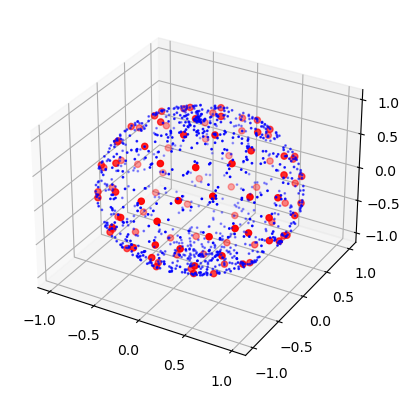

In [1]:
# generated by claude 3.5 sonnet

import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
def fps_sampling(points, n_samples):
    """
    Perform Farthest Point Sampling on the input point cloud.
    
    :param points: numpy array of shape (N, 3) representing the point cloud
    :param n_samples: number of points to sample
    :return: indices of sampled points
    """
    N = points.shape[0]
    sampled_indices = np.zeros(n_samples, dtype=int)
    distances = np.full(N, np.inf)
    
    # Randomly choose the first point
    sampled_indices[0] = np.random.randint(N)
    
    for i in range(1, n_samples):
        distances = np.minimum(distances, np.sum((points - points[sampled_indices[i-1]])**2, axis=1))
        sampled_indices[i] = np.argmax(distances)
    
    return sampled_indices

def fps_clustering_downsample(points, n_samples):
    """
    Downsample the point cloud using FPS and clustering.
    
    :param points: numpy array of shape (N, 3) representing the point cloud
    :param n_samples: number of points in the downsampled cloud
    :return: downsampled point cloud
    """
    # Perform FPS to get initial samples
    sampled_indices = fps_sampling(points, n_samples)
    sampled_points = points[sampled_indices]
    
    # Use K-means clustering to associate other points with the samples
    kmeans = KMeans(n_clusters=n_samples, init=sampled_points, n_init=1, max_iter=100)
    kmeans.fit(points)
    
    # Compute the new point positions as the mean of each cluster
    new_points = np.array([points[kmeans.labels_ == i].mean(axis=0) for i in range(n_samples)])
    
    return new_points


num_points = 1000
num_samples = 100

theta = np.random.random(num_points) * 2 * np.pi
phi = np.random.random(num_points) * np.pi
r = 1
x = r * np.sin(phi) * np.cos(theta)
y = r * np.sin(phi) * np.sin(theta)
z = r * np.cos(phi)
points = np.column_stack((x, y, z))

downsampled_points = fps_clustering_downsample(points, num_samples)


# visualize points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='blue', s=1)
ax.scatter(downsampled_points[:, 0], downsampled_points[:, 1], downsampled_points[:, 2], c='red')
plt.show()



# Trying To Speed Up FPS Sampling

In [2]:
def optimized_fps_sampling(points, n_samples):
    """
    Perform an optimized Farthest Point Sampling (FPS) using NumPy.

    :param points: numpy array of shape (N, 3) representing the point cloud
    :param n_samples: number of points to sample
    :return: indices of sampled points
    """
    N = points.shape[0]
    sampled_indices = np.zeros(n_samples, dtype=int)
    distances = np.full(N, np.inf)

    # Choose the first point randomly
    sampled_indices[0] = 0
    
    # Efficiently compute distances using vectorized operations
    for i in range(1, n_samples):
        # Update minimum distances
        diff = points - points[sampled_indices[i - 1]]
        new_distances = np.einsum('ij,ij->i', diff, diff)  # Faster squared Euclidean distance, equivalent to np.sum(diff**2, axis=1)
        distances = np.minimum(distances, new_distances)
        
        # Select the point farthest from the existing sampled set
        sampled_indices[i] = np.argmax(distances)

    sampled_points = points[sampled_indices]
    
    return sampled_points


In [3]:
import time

# Generate a random point cloud
points = np.random.rand(100000, 3)

# Number of samples
num_samples = 1000

# Measure time for the first implementation
start_time = time.time()
sampled_points_1 = fps_sampling(points, num_samples)
print("First Implementation Time:", time.time() - start_time)

# Measure time for the second implementation
start_time = time.time()
sampled_points_2 = optimized_fps_sampling(points, num_samples)
print("Second Implementation Time:", time.time() - start_time)


First Implementation Time: 1.3808441162109375
Second Implementation Time: 1.0883281230926514
